# Test File

In [25]:
import datetime as dt
import time
import os, errno
import copy
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np
import pandas as pd
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20.0, 8.0] # Default: [6.0, 4.0]

In [2]:
import xml.etree.ElementTree as ET
import zipfile
import csv

## Custom parse method so we can keep track of all the namespaces

In [3]:
NS_MAP = "xmlns:map"

# Method for parsing and keeping namespaces
def parse_nsmap(file):

    events = "start", "start-ns", "end-ns"

    root = None
    ns_map = []

    for event, elem in ET.iterparse(file, events):
        if event == "start-ns":
            ns_map.append(elem)
        elif event == "end-ns":
            ns_map.pop()
        elif event == "start":
            if root is None:
                root = elem
            elem.set(NS_MAP, dict(ns_map))

    return ET.ElementTree(root)

## Custom methods to get the full tag/attribute name using the namespaces

In [4]:
def getNS(elem, ns):
    return elem.get(NS_MAP).get(ns)

def getAttribNS(elem, ns, attr):
    return '{%s}%s' % (getNS(elem, ns), attr)

def attribWithNS(elem, ns, attr):
    return elem.attrib.get(getAttribNS(elem, ns, attr))

def tagWithNS(elem, ns, tag):
    return '{%s}%s' % (getNS(elem, ns), tag)

In [26]:
tag_dictionary_original = OrderedDict({
    'jdt:JdtSourceEditProposal': {
        'COUNTER': 0,
        'ATTEMPT': {
            'jdt:JdtSourceEditEvent': {
                'EVENT': 'SourceEdit',
                'ATTRIBUTES': {
                    'sizeMeasure': {
                        'COLUMN_NAME': 'SizeMeasure',
                        'CONVERT': int
                    },
                    'warningCount': {
                        'COLUMN_NAME': 'WarningCount',
                        'CONVERT': int
                    }
                }
            }
        }
    },
    'junit:JunitTestProposal': {
        'COUNTER': 0,
        'ATTEMPT': {
            'junit:JunitTestEvent' : {
                'EVENT': 'JunitTest',
                'ATTRIBUTES': {
                    'successCount': {
                        'COLUMN_NAME': 'SuccessCount',
                        'CONVERT': int
                    },
                    'failureCount': {
                        'COLUMN_NAME': 'FailureCount',
                        'CONVERT': int
                    },
                    'errorCount': {
                        'COLUMN_NAME': 'ErrorCount',
                        'CONVERT': int
                    },
                    'completion': {
                        'COLUMN_NAME': 'Completion',
                        'CONVERT': float
                    }
                }
            }
        }
    },
    'jdt:JdtLaunchProposal': {
        'COUNTER': 0,
        'ATTEMPT': {
            'jdt:JdtLaunchEvent': {
                'EVENT': 'Launch',
                'ATTRIBUTES': {
                    
                }
            }
        }
    }
})

In [30]:
def read_df_from_xml(xmlFile):
    data_list = []
    tree = parse_nsmap(xmlFile)
    root = tree.getroot()
    exerciseProposals = tree.find(tagWithNS(root, 'exercise', 'ExerciseProposals'))
    if exerciseProposals is None:
        return None
    print(exerciseProposals.tag)
    tag_dictionary = copy.deepcopy(tag_dictionary_original)
    for proposalParts in exerciseProposals:
        print('Exercise part:', proposalParts.attrib.get('exercisePart'))
        for taskProposals in proposalParts:
            task_type = attribWithNS(taskProposals, 'xsi', 'type')
            print('Task type:', task_type)
            task_dictionary = None
            if task_type in tag_dictionary:
                task_dictionary = tag_dictionary[task_type]
                task_dictionary['COUNTER'] += 1
            else:  # F.ex: workbench:DebugEventProposal
                continue
            for attempts in taskProposals:
                print('Attempt type:', attribWithNS(attempts, 'xsi', 'type'))
                timestamp = int(attempts.attrib.get('timestamp'))
                attemptDateTime = dt.datetime.fromtimestamp(int(timestamp / 1e3))  # Divide by 1000 to get from ms to seconds
                print('Attempt date time:', attemptDateTime)
                data_dict = OrderedDict()
                for attempt_type_name, attempt_dict in task_dictionary['ATTEMPT'].items():
                    data_dict[attempt_dict['EVENT'] + str(task_dictionary['COUNTER'])] = None
                    for attr, attr_dict in attempt_dict['ATTRIBUTES'].items():
                            data_dict[attr_dict['COLUMN_NAME'] + str(task_dictionary['COUNTER'])] = None
                if getAttribNS(attempts, 'xsi', 'type') not in attempts.attrib:  # Some kind of error in the xml file?
                    continue
                attempt_type = attribWithNS(attempts, 'xsi', 'type')
                if attempt_type in task_dictionary['ATTEMPT']:
                    attempt_dictionary = task_dictionary['ATTEMPT'][attempt_type]
                    data_dict[attempt_dictionary['EVENT'] + str(task_dictionary['COUNTER'])] = 1
                    for attribute, attribute_spec in attempt_dictionary['ATTRIBUTES'].items():
                        column_name = attribute_spec['COLUMN_NAME'] + str(task_dictionary['COUNTER'])
                        convert_method = attribute_spec['CONVERT']
                        if attribute in attempts.attrib:  # TODO: If attribute never occurs; no column for it!
                            data_dict[column_name] = convert_method(attempts.attrib.get(attribute))
                data_list.append([attemptDateTime, data_dict])
            print('--------------')
        print()
    data_list.sort(key=lambda x: x[0])  # Sorting by timestamp (attemptDateTime)
    df_index = pd.DatetimeIndex([x[0] for x in data_list])
    df = pd.DataFrame([x[1] for x in data_list], index=df_index)
    return df

In [43]:
def save_all_xml_from_zip_to_csv(path):
    files_loaded = 0
    files_discarded = 0
    with zipfile.ZipFile(path, 'r') as myzip:
        exFileList = myzip.namelist()
        for exFilePath in exFileList:
            with myzip.open(exFilePath, 'r') as xmlFile:
                files_loaded += 1
                split_path = exFilePath.split('/')
                file_name = split_path[-1][:-3]
                user_name = split_path[-2]
                exercise_name = split_path[-3]
                directory = '../data/csv/%s/%s' % (exercise_name, user_name)
                try:
                    os.makedirs(directory)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
                df = read_df_from_xml(xmlFile)
                if df is None:
                    files_discarded += 1
                    continue
                save_path = '%s/%s.csv' % (directory, file_name)
                df.to_csv(save_path, mode='w+')
    print('Files loaded:', files_loaded)
    print('Files discarded:', files_discarded)
    print('{}%'.format((files_loaded - files_discarded) / files_loaded * 100))

In [44]:
save_all_xml_from_zip_to_csv('../data/oving6-anon.zip')

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 12:11:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 21:35:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 21:45:44
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:04:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 12:11:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 21:35:28
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:08:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 12:11:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 21:27:07
Attempt type: jdt:JdtSourceEditE

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:42:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:42:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:42:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:45:54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:47:33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:54:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:57:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:58:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:59:33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:03:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:04:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:05:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:07:36
Attempt type

Attempt date time: 2017-03-06 22:53:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:54:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:55:41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:56:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:56:50
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-06 22:48:47
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-06 22:49:02
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-06 22:50:36
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-06 22:51:28
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-06 22:52:03
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-06 22:52:37
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-06 22:53:29
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 15:50:05
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 16:29:49
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 17:55:21
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 16:01:12
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 17:55:27
--------------

Exercise part: /0/@parts.2
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 16:07:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 16:08:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 16:23:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 16:29:07
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 17:03:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 17:07:46
Attempt type: jdt:JdtSourceEditEvent
Attempt

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:04:07
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:04:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:16:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:16:40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:27:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:38:04
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:41:30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:43:19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:51:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:51:36
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:59:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:00:55
Attempt type: jdt:JdtSourceEditEvent

Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:59:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 18:02:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 22:19:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 22:20:30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:12:37
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 18:02:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 18:15:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:10:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:22:34
Attempt type: jdt:JdtSource

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 20:26:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 20:48:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 20:50:55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 20:52:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 20:55:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:06:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:13:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:16:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:17:17
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:06:11
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:16:18
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-28 21:17

Attempt date time: 2017-03-07 22:07:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 22:07:54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:01:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:16:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:31:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:37:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:38:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 23:38:24
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-08 00:33:53
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-08 00:34:38
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-08 00:35:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-08 00:36:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-08 00:36:58
Attempt type: jdt:Jdt

Attempt date time: 2017-03-02 11:21:47
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 10:25:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 10:25:48
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 10:36:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 10:58:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 11:14:48
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 11:18:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 11:18:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 11:19:18
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 10:49:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 10:58:30
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
-

Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:12:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:12:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:13:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:14:54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:18:28
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:15:32
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:16:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:17:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:17:31
Attempt type: jdt:JdtSourceEditEvent
Attempt 

Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 14:15:06
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 14:18:04
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 14:22:19
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 15:36:36
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 15:38:45
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:50:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 14:27:55
Attempt type: jdt:JdtSour

Attempt date time: 2017-03-07 22:54:46
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 22:56:01
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 22:59:46
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:07:15
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:14:08
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:20:55
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:21:34
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:23:26
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:23:47
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:25:11
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:25:22
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:38:05
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:39:04
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 23:39:31

Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 16:38:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 17:45:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 17:48:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 17:48:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 17:48:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 17:49:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 17:49:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 17:50:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 18:03:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 18:03:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 18:14:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 18:22:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date t

--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 18:17:05
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 18:18:24
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 18:22:34
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 18:27:54
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 18:30:14
--------------

Exercise part: /0/@parts.2
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 21:30:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 21:31:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 21:32:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 21:34:50
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 21:35:06
--------------

Exercise

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 15:20:24
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 15:21:33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 19:33:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 19:42:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 19:43:01
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 20:54:40
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 20:54:51
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 21:35:12
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-03 22:13:46
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-04 17:45:52
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-04 17:45:57
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-04 18:11:55
Attempt type: jdt:Jd

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:47:10
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:49:23
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:51:49
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:52:23
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:53:42
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:53:55
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:54:21
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 20:56:00
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 21:00:10
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 21:00:21
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 21:03:44
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 21:06:22
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 21:06:30
Attempt type: junit:JunitTestEvent
Att

--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:30:59
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:31:07
--------------

Exercise part: /0/@parts.2
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:29:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:30:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:37:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:42:55
--------------
Task type: jdt:JdtLaunchProposal
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-08 00:42:54
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:31:21
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:37:38
--------------

Exercise part: /0/@parts.3
Task ty

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:17:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:18:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:18:41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:19:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:23:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:24:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:24:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:25:04
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:25:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:25:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:25:32
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:25:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 02:26:10
Attempt type

Attempt date time: 2017-03-06 21:11:05
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:12:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:22:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:26:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:28:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:29:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:30:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:30:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:49:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:50:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:50:42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:56:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:56:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date

Attempt date time: 2017-03-08 00:12:01
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:13:31
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:14:06
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:16:21
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 00:20:54
--------------

Exercise part: /0/@parts.2
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:30:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:33:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:27:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:27:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:28:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:30:48
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:32:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date tim

Attempt date time: 2017-02-26 12:40:29
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 12:41:39
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 12:51:30
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 13:00:16
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 13:03:05
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 13:32:51
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 12:59:24
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 13:32:39
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSource

Attempt date time: 2017-03-05 18:31:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 18:32:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 18:33:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:01:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 21:06:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 21:07:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 22:12:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 22:13:29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 22:14:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 22:16:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 22:16:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 22:18:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 22:18:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date

Attempt date time: 2017-03-08 01:24:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:24:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:24:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:24:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:24:54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:24:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:24:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:25:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:25:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:26:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:26:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:26:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 01:26:48
Attempt type: jdt:JdtSourceEditEvent
Attempt date

Attempt date time: 2017-03-07 13:46:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 13:46:59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:03:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:03:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:05:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:05:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:06:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:06:53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:10:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:17:40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:08:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:08:15
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 14:18:

Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:27:20
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:29:07
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 16:51:43
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 16:53:24
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal

Attempt date time: 2017-03-01 20:43:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 21:08:24
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 21:11:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 21:11:47
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 20:40:29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 20:41:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 20:41:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 20:44:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 21:12:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 21:13:15
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 20:45:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 20:47:32
Attempt type: jdt:Jdt

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:26:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:26:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:26:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:35:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:36:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:36:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:39:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:40:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:40:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:40:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:41:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:41:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-04 16:42:20
Attempt type

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:28:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:28:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:28:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:28:48
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:34:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:49:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:53:07
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:53:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:53:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-14 11:57:00
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:49:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 21:07:50
Attempt type: jdt:JdtSourceEditEvent

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:40:07
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:44:32
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:44:46
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 13:18:36
--------------
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 13:58:01
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07

Attempt date time: 2017-03-07 11:35:24
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 11:30:33
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 11:35:31
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 11:43:51
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtSourceEditProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt da

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 09:21:14
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 14:07:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 14:12:08
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 14:12:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 14:19:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 14:20:39
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt dat

Attempt date time: 2017-03-08 08:22:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 08:22:59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 08:23:23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 08:23:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 08:23:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 08:24:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 08:24:19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 08:25:52
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 07:08:05
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 08:17:26
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 08:17:38
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 14:31:04
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 10:16:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 10:43:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 10:58:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 10:58:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 10:59:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 11:00:30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 11:01:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 11:02:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 11:09:21
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 14:25:51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 14:26:37
Attempt type: jdt:JdtSourceEditEvent

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:11:41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:11:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:12:03
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:00:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:00:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:00:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:00:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:00:21
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:08:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:08:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:09:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-02 13:10:23
Attempt type: jdt:JdtSourceEditEvent

Exercise part: /0/@parts.3
Task type: workbench:DebugEventProposal
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 18:49:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 18:51:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 18:54:42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 18:55:33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:03:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:04:55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:07:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:09:38
--

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 16:25:01
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 16:25:51
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 16:26:10
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-08 16:26:41
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:37:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:43:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:43:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 00:48:14
Attempt type: jdt:JdtSourceEditEve

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-27 13:19:30
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-27 13:19:46
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-27 13:07:21
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-27 13:09:33
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-27 13:24:53
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:08:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:13:57
------------

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:40:59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:42:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:52:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:53:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:54:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:54:21
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:56:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:56:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:58:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:58:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 16:58:16
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: juni

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 13:29:38
--------------

Exercise part: /0/@parts.2
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 12:38:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 12:51:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 12:56:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 12:56:55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:10:33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:10:41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:11:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:13:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:34:29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:35:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:36:51
----------

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:10:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:10:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:10:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:10:29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:10:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:10:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:11:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:11:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:11:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:11:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:11:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:13:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-24 11:13:29
Attempt type

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 14:14:15
--------------

Exercise part: /0/@parts.3
Task type: workbench:DebugEventProposal
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:34:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:38:02
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:38:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:59:17
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 15:45:35
Attempt type: jdt:JdtSourceEditEvent

--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 12:32:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:18:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:24:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:26:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:26:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:27:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:30:54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:31:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:31:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:43:07
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:43:23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:43:48
Attempt type: jdt:JdtSourceEditEvent

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:12:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:14:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:25:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:35:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:40:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:41:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:44:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:49:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 15:50:19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 16:02:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 16:03:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 16:04:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 16:06:11
Attempt type

Attempt date time: 2017-03-08 04:54:05
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 04:54:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 04:56:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:00:30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:00:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:02:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:07:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:07:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:07:51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:08:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:08:41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:09:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-08 05:09:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date

Attempt date time: 2017-03-02 17:32:09
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:32:42
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:33:19
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:34:39
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:34:57
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:35:06
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:36:31
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:36:37
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:37:17
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:38:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:38:12
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:39:10
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:39:22
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-02 17:40:15
Attempt type: jdt:JdtLaun

Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:09:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:10:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:10:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:11:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:11:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:12:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:12:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:12:42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-03 00:14:36
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTe

Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:01:04
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:01:16
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:01:27
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:01:31
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:01:48
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:01:53
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:02:10
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:02:15
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:02:35
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:03:00
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:03:27
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:04:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 09:06:25
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 0

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:06:24
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:07:53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:08:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:08:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:09:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:09:40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:09:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:10:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:10:32
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:32:29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:43:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:44:24
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:45:23
Attempt type

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:51:54
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:54:45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:56:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:57:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:57:55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:59:35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:59:41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:08:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 21:10:02
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:55:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 20:56:14
Attempt type: jdt:JdtSourceEditE

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:13:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:13:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:13:45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:14:04
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:14:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:14:30
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:16:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:16:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:16:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:16:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:17:07
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:17:23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-22 21:17:26
Attempt type

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 22:11:41
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 22:12:15
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 22:16:31
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:12:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:13:29
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:13:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date ti

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 15:43:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 15:51:24
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 15:51:45
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-02-26 15:51:50
--------------

Exercise part: /0/@parts.2
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 15:53:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 16:04:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 16:04:35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 16:12:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 16:17:29
Attempt type: jdt:JdtSourceEditEvent
Attempt

Attempt date time: 2017-03-07 19:32:19
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:35:31
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:35:44
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:35:57
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:36:25
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:36:44
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:37:55
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:38:01
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:38:34
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:40:22
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-07 19:40:41
--------------
Task type: junit:JunitTestProposal
--------------

Exercise part: /0/@parts.3
Task type: workbench:DebugEventProposal
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:C

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 13:00:58
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:19:49
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 12:59:52
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 13:00:37
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 13:00:50
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:19:42
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 12:59:55
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 13:01:00
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:19:53
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 12:59:48
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 13:00:04
Attempt type: junit:JunitTestEvent
A

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 15:17:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 15:19:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 15:34:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 15:43:40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:57:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:38:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:41:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:42:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:43:23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:43:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:43:57
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:44:40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:44:52
Attempt type

Attempt date time: 2017-03-01 13:49:32
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:49:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:50:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:51:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:52:59
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:53:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:54:32
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:55:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:56:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:56:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:57:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:57:53
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 13:58:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:48:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:51:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:51:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:51:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:51:51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:53:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:54:23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:55:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:55:21
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:55:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:55:55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:56:14
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-26 23:56:25
Attempt type

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:50:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:50:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:50:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:50:33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:50:45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:51:42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:52:04
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:52:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:52:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:52:54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:53:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:53:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 10:53:36
Attempt type

Attempt date time: 2017-03-06 18:39:11
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 18:39:19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 18:39:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 18:42:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 18:55:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 18:55:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:24:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:25:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 15:26:05
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 15:24:04
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 15:24:08
Attempt t

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:12:03
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:34:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:35:36
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:37:34
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:57:26
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:36:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:36:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:39:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:45:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:47:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:49:05
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 22:53:13
Attempt type: jdt:JdtSourceEditEvent

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:23:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:28:28
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:33:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:35:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:39:41
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:42:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:42:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:42:55
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:43:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:43:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:45:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:46:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:46:48
Attempt type

Attempt date time: 2017-03-05 13:21:33
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:23:00
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:23:31
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:23:58
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:24:56
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:26:23
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:26:44
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:27:27
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:35:41
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:35:48
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:36:02
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:36:40
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:36:46
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-05 13:36:55
Attempt type: jdt:JdtLaun

Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-03 13:21:08
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-03 13:24:23
Attempt type: jdt:JdtLaunchEvent
Attempt date time: 2017-03-03 13:25:18
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-02 15:58:01
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-03 13:19:19
--------------

Exercise part: /0/@parts.3
Task type: workbench:DebugEventProposal
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 17:27:26
Attempt type: jdt:JdtSou

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:01:31
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:05:16
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:07:17
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:08:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:08:15
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:11:54
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:13:09
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:13:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:16:53
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:14:29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-25 15:15:27
Attempt type: jdt:JdtSourceEditEvent
Attempt dat

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:06:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:07:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:07:31
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:07:50
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:07:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:08:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:08:51
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:09:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:09:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:11:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-01 11:11:46
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditE

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:16:07
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:21:42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:22:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:26:40
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:27:45
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:28:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:46:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:47:00
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:48:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:53:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:53:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 19:55:58
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 20:02:01
Attempt type

Attempt date time: 2017-03-03 10:58:32
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-03 10:59:54
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-03 11:01:14
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 09:13:17
--------------

Exercise part: /0/@parts.1
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:35:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:37:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:46:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19:50:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 19

Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 16:11:07
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 16:13:14
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 16:36:37
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 16:49:04
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 16:50:36
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 17:04:03
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 17:45:31
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 17:48:31
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 17:56:41
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 17:57:19
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 18:28:03
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 18:31:50
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 18:34:58
Attempt type: junit:JunitTestEvent
Att

Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:38:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:38:46
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:39:33
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 13:39:42
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:34:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:34:49
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:35:21
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:35:39
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:45:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:46:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:46:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 11:47:06
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 12:45:24
Attempt type

Attempt date time: 2017-03-06 17:11:43
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 17:11:47
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 17:12:35
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 17:12:37
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 17:51:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 09:50:39
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 17:14:54
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-06 17:15:02
--------------

Exercise part: /0/@parts.2
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 16:38:25
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-06 16:42:57
Attem

Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:PartTaskProposal

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:28:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:30:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:31:23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:31:23
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:57:19
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:57:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:57:24
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-07 17:36:52
Attempt type: jdt

Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 14:22:02
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 14:25:04
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 14:37:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 14:49:26
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 14:50:18
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 15:04:07
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-03-05 15:28:23
--------------
Task type: jdt:JdtLaunchProposal
--------------
Task type: junit:JunitTestProposal
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-05 17:12:41
Attempt type: junit:JunitTestEvent
Attempt date time: 2017-03-07 14:24:42
--------------

Exercise part: /0/@parts.2
Task type: workbench:DebugEventProposal
Task type: workbench:CommandExecutionProposal
Task type: workbench:CommandExecutionProposal
Task type:

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:27:56
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:37:10
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:40:08
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:55:49
--------------

Exercise part: /0/@parts.1
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:40:27
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:55:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:57:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 21:58:22
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:02:52
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-28 22:06:50
Attempt 

In [15]:
#p = '../data/oving5/0245601978/Partner.ex'
p = '../data/oving5/0141126194/Card.ex'
df = None
with open(p, 'r') as xml_file:
    split_path = p.split('/')
    file_name = split_path[-1][:-3]
    user_name = split_path[-2]
    df = read_df_from_xml(xml_file)

{platform:/plugin/no.hal.learning.exercise.model/model/exercise.ecore}ExerciseProposals
Exercise part: /0/@parts.0
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 22:56:38
--------------
Task type: jdt:JdtSourceEditProposal
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 22:56:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 22:59:29
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:13:12
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:16:13
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:16:44
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:18:20
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:18:38
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:31:01
Attempt type: jdt:JdtSourceEditEvent
Attempt date time: 2017-02-23 23:34:25
Attempt type: jdt:JdtSourceEditEvent

In [11]:
df.columns

Index(['SourceEdit1', 'SizeMeasure1', 'WarningCount1', 'SourceEdit2',
       'SizeMeasure2', 'WarningCount2', 'JunitTest1', 'SuccessCount1',
       'FailureCount1', 'ErrorCount1', 'Completion1', 'SourceEdit3',
       'SizeMeasure3', 'WarningCount3', 'JunitTest2', 'SuccessCount2',
       'FailureCount2', 'ErrorCount2', 'Completion2', 'JunitTest3',
       'SuccessCount3', 'FailureCount3', 'ErrorCount3', 'Completion3',
       'Launch1'],
      dtype='object')

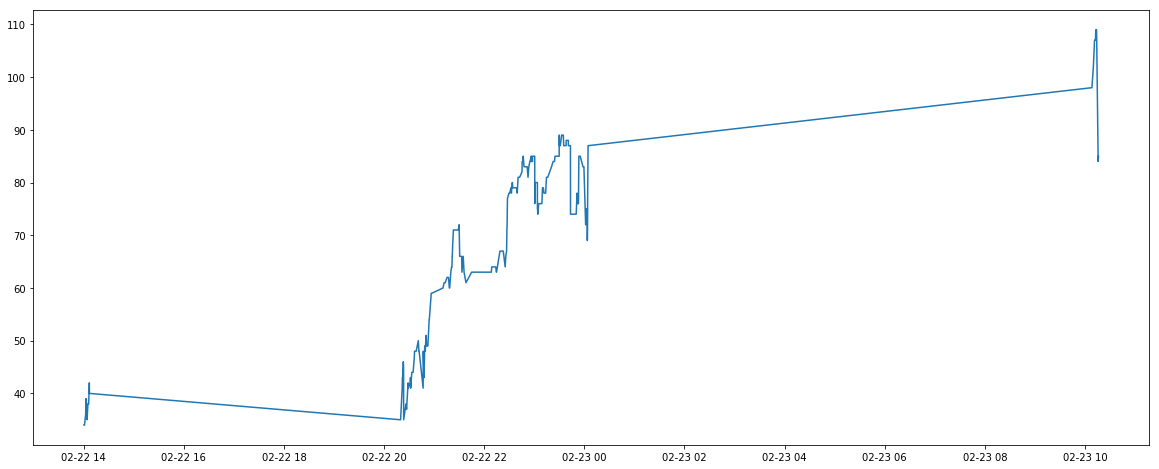

In [96]:
plt.plot(df.loc[:].SizeMeasure)

In [12]:
df.plot()

AttributeError: 'NoneType' object has no attribute 'plot'

In [13]:
snippet = df#.loc['2017-02-23 00:00:00':'2017-02-23 10:30:00']
snippet.SizeMeasure.plot(label="SizeMeasure", legend=True)
snippet.SourceEdit.plot(secondary_y=True, label="SourceEdit", legend=True)

AttributeError: 'NoneType' object has no attribute 'SizeMeasure'

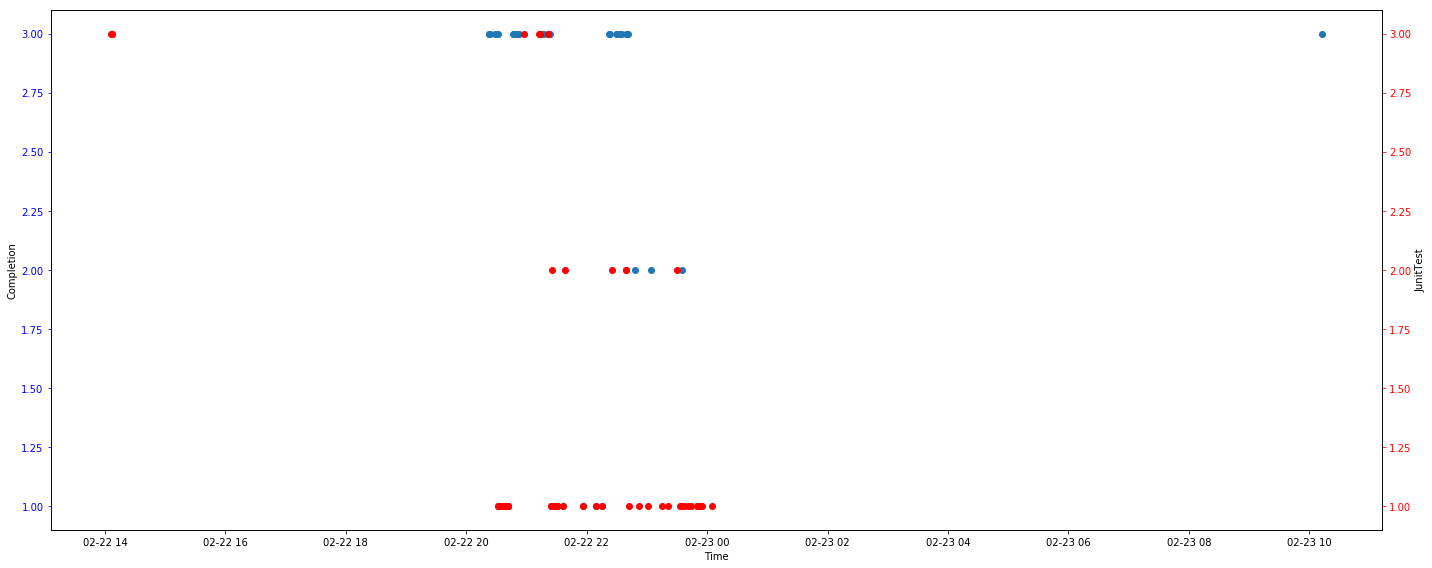

In [65]:
fig, ax1 = plt.subplots()
ax1.plot(df.ErrorCount, marker='o', linestyle="None")
ax1.set_xlabel('Time')
ax1.set_ylabel('Completion')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df.FailureCount, marker='o', linestyle="None", color='r')
ax2.set_ylabel('JunitTest')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()